In [66]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pingouin as pg
from scipy import optimize, special, stats
from sklearn import linear_model
from tqdm import tqdm
import tabulate
import types
import warnings

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})
np.set_printoptions(suppress=True)
pd.options.display.max_columns = 100
pd.options.display.max_rows    = 200
color_cycle = ['#332288', '#88CCEE', '#44AA99', '#117733', '#999933', '#DDCC77', '#CC6677', '#882255', '#AA4499']
color_map = lambda x : color_cycle[x]

In [2]:
def imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            try:
                yield val.__name__, val.__version__
                pass
            except:
                yield val.__name__
                pass
            pass
        pass
    pass

list(imports())

['builtins',
 'builtins',
 ('matplotlib', '3.8.2'),
 'matplotlib.pyplot',
 ('numpy', '1.24.3'),
 'os',
 ('pandas', '2.1.4'),
 ('pingouin', '0.5.4'),
 'scipy.optimize',
 'scipy.special',
 'scipy.stats',
 'sklearn.linear_model',
 ('tabulate', '0.9.0'),
 'types']

In [3]:
data_location = '../data/processed_data/'
dataset = pd.read_csv(data_location + 'data.csv.gz', low_memory=False)
number_duplicate_reviews = dataset.groupby('recommendation_id').size() == 60

In [18]:
print('{:,} reviews in total'.format(dataset.shape[0]//30))
print('{:,.0f} duplicates ({}%)'.format(number_duplicate_reviews.sum(), round(100*number_duplicate_reviews.mean(), 1)))
dataset = dataset.groupby('recommendation_id').filter(lambda x : x.shape[0] == 30).reset_index(drop=True)
print('{:,} reviews after excluding duplicates'.format(dataset.shape[0]//30))

3,264,943 reviews in total
183,791 duplicates (6.0%)
2,897,361 reviews after excluding duplicates


In [71]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    aov = pg.rm_anova(data=dataset, dv='similarity_score', within=['order', 'similarity_type'], subject='recommendation_id', effsize='np2', correction=True)
    pass
pg.print_table(aov)


ANOVA SUMMARY

Source                          SS    ddof1     ddof2        MS           F    p-unc    p-GG-corr    np2    eps
-----------------------  ---------  -------  --------  --------  ----------  -------  -----------  -----  -----
order                      150.813        9  26076240    16.757     639.110    0.000        0.000  0.000  0.999
similarity_type          16395.303        2   5794720  8197.651  234837.995    0.000        0.000  0.075  0.973
order * similarity_type    275.580       18  52152480    15.310     583.969    0.000        0.000  0.000  0.972



In [72]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    posthoc = pg.pairwise_tests(data=dataset, dv='similarity_score', within=['similarity_type'], subject='recommendation_id', correction=True, parametric=True, effsize='cohen', padjust='holm')
    pass
pg.print_table(posthoc)


POST HOC TESTS

Contrast         A         B         Paired    Parametric           T          dof  alternative      p-unc    p-corr  p-adjust       BF10    cohen
---------------  --------  --------  --------  ------------  --------  -----------  -------------  -------  --------  ----------  -------  -------
similarity_type  control   main bar  True      True          -572.308  2897360.000  two-sided        0.000     0.000  holm        inf       -0.170
similarity_type  control   sidebar   True      True            -4.930  2897360.000  two-sided        0.000     0.000  holm        125.911   -0.001
similarity_type  main bar  sidebar   True      True           568.115  2897360.000  two-sided        0.000     0.000  holm        inf        0.168



In [70]:
dataset.groupby('similarity_type').apply(lambda x : (print(x['similarity_type'].unique()[0]), pg.print_table(pg.rm_anova(data=x, dv='similarity_score', within='order', subject='recommendation_id', effsize='np2', correction=True))));

control

ANOVA SUMMARY

Source      ddof1     ddof2      F    p-unc    p-GG-corr    np2    eps  sphericity      W-spher    p-spher
--------  -------  --------  -----  -------  -----------  -----  -----  ------------  ---------  ---------
order           9  26076240  0.292    0.977        0.977  0.000  1.000  False             1.000      0.000

main bar

ANOVA SUMMARY

Source      ddof1     ddof2         F    p-unc    p-GG-corr    np2    eps  sphericity      W-spher    p-spher
--------  -------  --------  --------  -------  -----------  -----  -----  ------------  ---------  ---------
order           9  26076240  2242.721    0.000        0.000  0.001  0.991  False             0.956      0.000

sidebar

ANOVA SUMMARY

Source      ddof1     ddof2      F    p-unc    p-GG-corr    np2    eps  sphericity      W-spher    p-spher
--------  -------  --------  -----  -------  -----------  -----  -----  ------------  ---------  ---------
order           9  26076240  2.406    0.010        0.010  0.

In [21]:
plot_by_game = False
plot_colors = np.array([np.array([30,75,137, 255])/255, [0.    , 0.1262, 0.3015, 1.    ], [0.4456, 0.4477, 0.4547, 1.    ], [0.9082, 0.8219, 0.3474, 1.    ]])
descriptives = {}
regression = linear_model.LinearRegression()
for game_id in dataset['game_id'].unique():
    data = dataset[dataset['game_id'] == game_id].copy()
    by_order = data.groupby('order')['similarity_score'].mean()
    by_type = data.groupby('similarity_type')['similarity_score'].mean()
    by_both = data.groupby(['similarity_type', 'order'])['similarity_score'].mean()
    means = {'mean main bar' : by_type['main bar'], 'mean sidebar' : by_type['sidebar'], 'mean control' : by_type['control']}
    slopes = by_both.groupby('similarity_type').apply(lambda xxx : regression.fit(X=np.arange(len(xxx))[:, None], y=xxx.values).coef_[0]).rename({'main bar' : 'slope main bar', 'sidebar' : 'slope sidebar', 'control' : 'slope control'}).to_dict()
    temp_line = means | slopes
    descriptives[game_id] = temp_line
    if plot_by_game:
        f, axarr = plt.subplots(1, 1, figsize = (20, 14), gridspec_kw={'wspace' : 0.2, 'hspace' : 0.05})
        f.patch.set_alpha(0)
        axarr.plot(by_both.get('main bar').index+1, by_both.get('main bar').values, color=plot_colors[0], lw=10, label='Main bar')
        axarr.plot(by_both.get('sidebar').index+1, by_both.get('sidebar').values,   color=plot_colors[3], lw=10, label='Side bar')
        axarr.plot(by_both.get('control').index+1, by_both.get('control').values,   color=plot_colors[2], lw=10, label='Control')
        xticks = np.arange(1, 11)
        xticklabels = [r'\fontfamily{ptm}\selectfont{%d}' % xxx for xxx in xticks]
        axarr.set_xlabel(r'\fontfamily{ptm}\selectfont{Order (top to bottom)}', fontsize=50, labelpad=25)
        axarr.set_ylabel(r'\fontfamily{ptm}\selectfont{Similarity difference to reference}', fontsize=50, labelpad=25)
        max_val = by_both.max()
        min_val = by_both.min()
        lim_diff = 0.05 * (max_val-min_val)
        yticks_range = round(min_val-lim_diff, 2), round(max_val+lim_diff, 2)
        yticks = np.arange(yticks_range[0], yticks_range[1], .05)
        yticklabels = [r'\fontfamily{ptm}\selectfont{%s%s}' % ('-' if xx < 0 else '', str(abs(xx))[1:]) for xx in yticks.round(2)]
        axarr.set_xticks(xticks)
        axarr.set_xticklabels(xticklabels, fontsize=50, ha='center')
        axarr.set_yticks(yticks)
        axarr.set_yticklabels(yticklabels, fontsize=50)
        axarr.tick_params(length=10, direction='out', width=5, pad=10, labelsize=50)   
        axarr.set_ylim(min_val-lim_diff, max_val+lim_diff)
        axarr.set_xlim(min(xticks)-0.5, max(xticks)+0.5)
        axarr.axhline(0, lw=5, color='0')
        [axarr.spines[i].set_linewidth(5) for i in axarr.spines.keys()]
        axarr.spines['right'].set_visible(False)
        axarr.spines['top'].set_visible(False)
        axarr.xaxis.set_ticks_position('bottom')
        axarr.yaxis.set_ticks_position('left')
        axarr.legend(bbox_to_anchor=(.95, .3), frameon=False, loc=1, borderaxespad=0, fontsize=50)
        axarr.text(x=1, y=1, s=r'\fontfamily{ptm}\selectfont{N = %s reviews}' % data['recommendation_id'].nunique(), transform=axarr.transAxes, ha='right', va='top', fontsize=60)
        plt.savefig('../figures/by_game/{}.pdf'.format(game_id), bbox_inches='tight')
        plt.close()
        pass
    pass
descriptives = pd.DataFrame(descriptives).T
descriptives['N_reviews'] = dataset.groupby('game_id').size()

In [22]:
(descriptives['mean main bar'] > descriptives['mean control']).mean()

0.7190201729106628

In [23]:
(descriptives['mean sidebar'] > descriptives['mean control']).mean()

0.5590778097982709

In [24]:
(descriptives > 0).mean().round(2)

mean main bar     1.00
mean sidebar      1.00
mean control      1.00
slope control     0.48
slope main bar    0.31
slope sidebar     0.46
N_reviews         1.00
dtype: float64

In [79]:
(descriptives.loc[descriptives['N_reviews'] >= np.percentile(descriptives['N_reviews'], 50), 'mean main bar'] > descriptives.loc[descriptives['N_reviews'] >= np.percentile(descriptives['N_reviews'], 50), 'mean control']).mean()

0.7936962750716332

In [78]:
(descriptives.loc[descriptives['N_reviews'] >= np.percentile(descriptives['N_reviews'], 50), 'mean sidebar'] > descriptives.loc[descriptives['N_reviews'] >= np.percentile(descriptives['N_reviews'], 50), 'mean control']).mean()

0.6217765042979942

In [25]:
(descriptives[descriptives['N_reviews'] >= np.percentile(descriptives['N_reviews'], 50)] > 0).mean().round(2)

mean main bar     1.00
mean sidebar      1.00
mean control      1.00
slope control     0.48
slope main bar    0.31
slope sidebar     0.40
N_reviews         1.00
dtype: float64

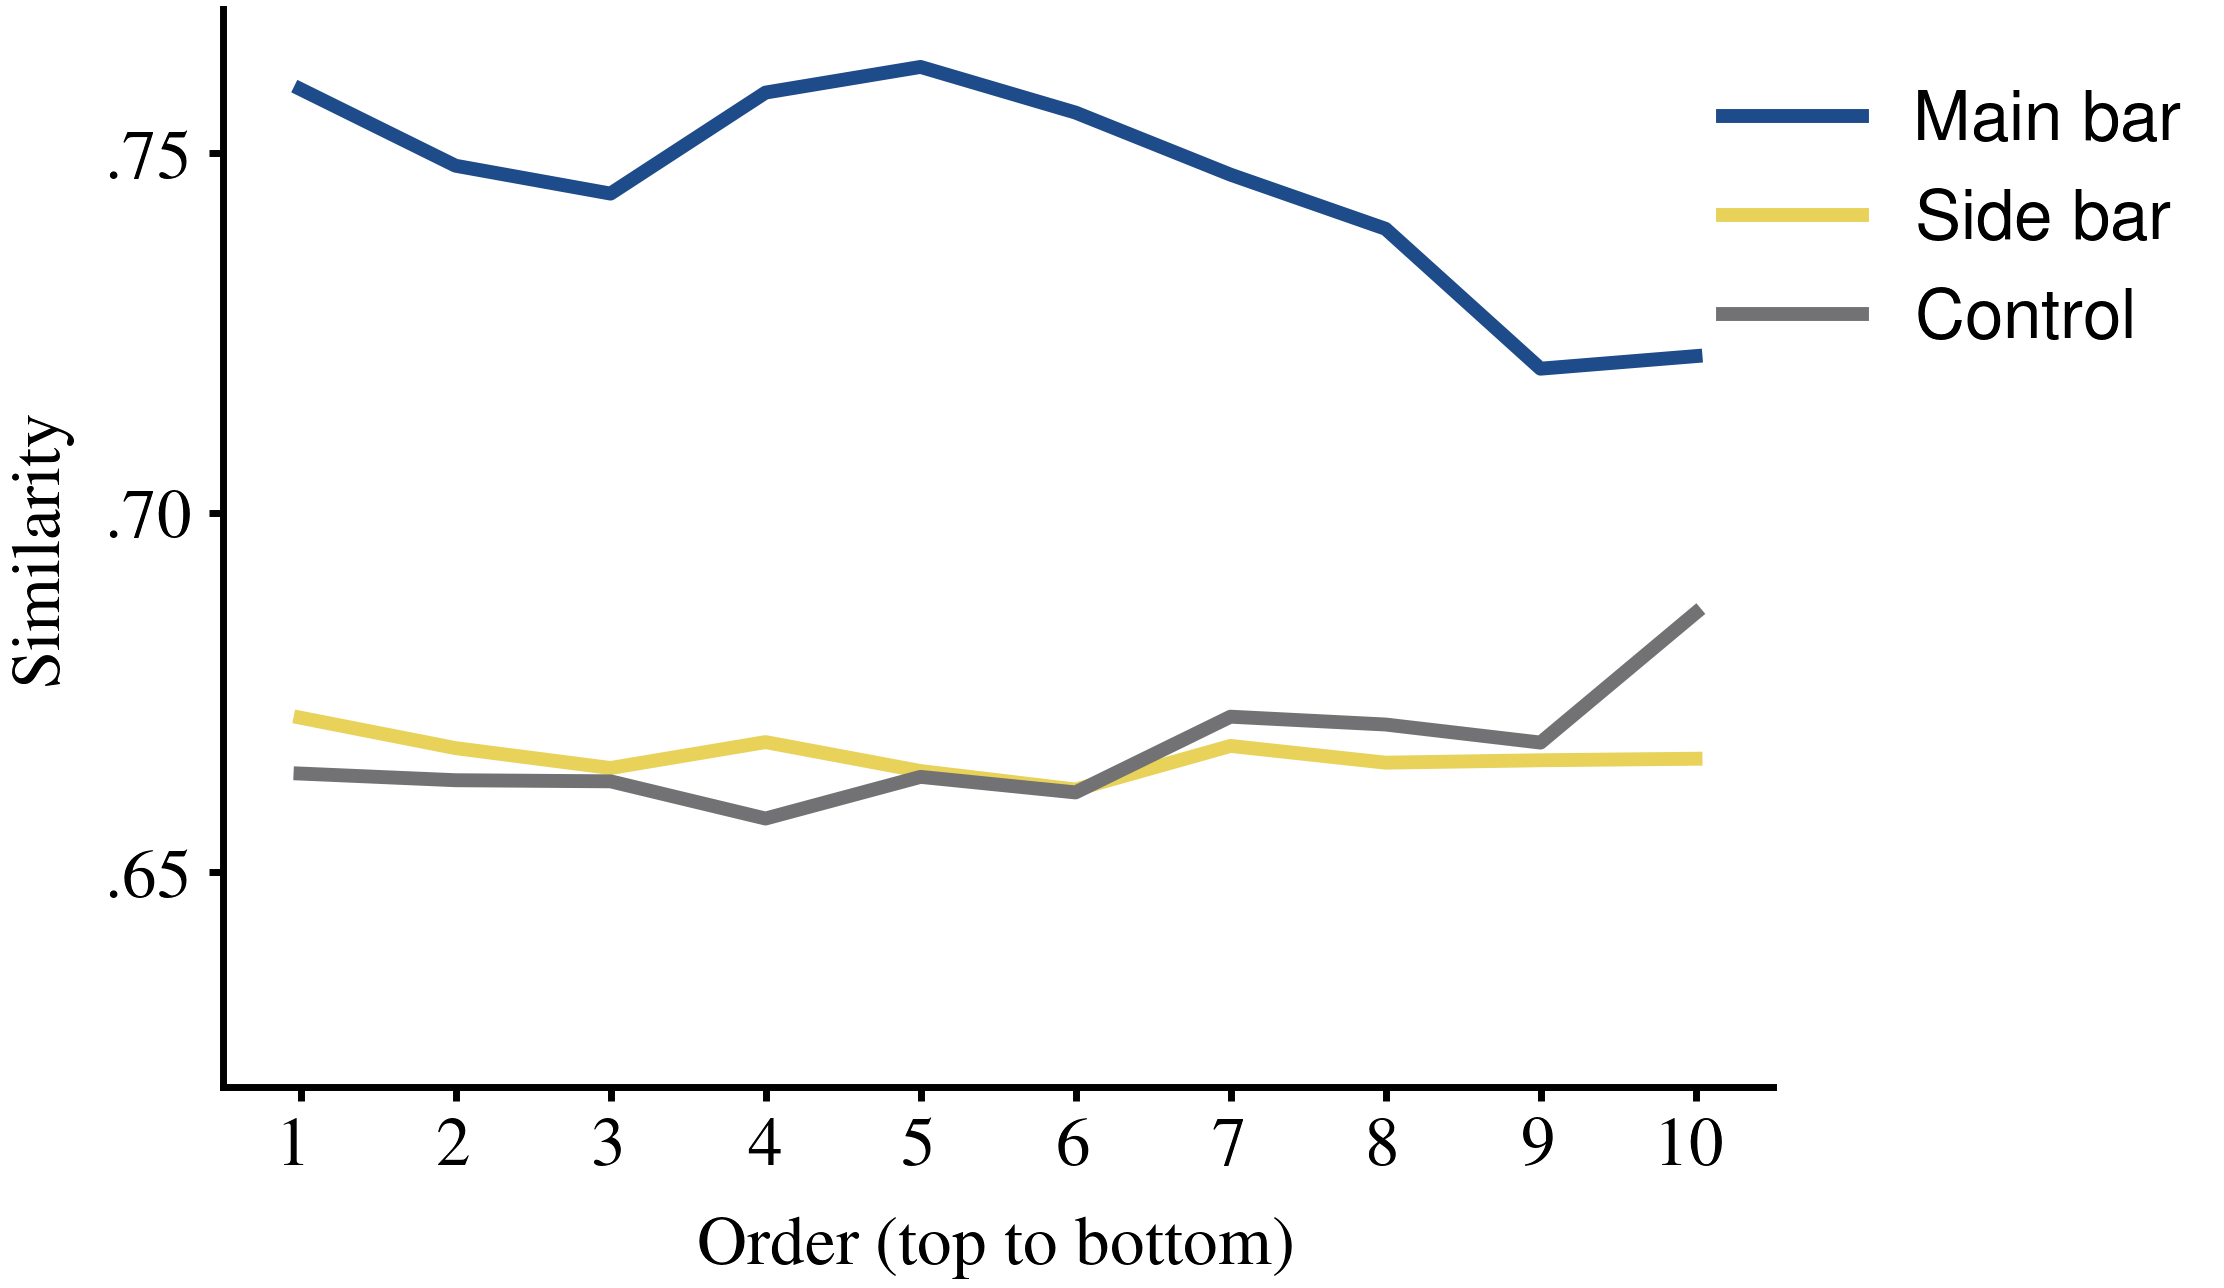

In [69]:
SE = data.groupby(['similarity_type', 'order'])['similarity_score'].std(ddof=1)/np.sqrt(data.groupby(['similarity_type', 'order'])['similarity_score'].size())
CI = stats.norm.ppf(.975) * SE

plot_colors = np.array([np.array([30,75,137, 255])/255,
                        [0.    , 0.1262, 0.3015, 1.    ],
                        [0.4456, 0.4477, 0.4547, 1.    ],
                        [0.9082, 0.8219, 0.3474, 1.    ]])

mpl.rcParams['hatch.linewidth'] = 5
mpl.rcParams['hatch.color'] = '1'
f, axarr = plt.subplots(1, 1, figsize = (20, 14), gridspec_kw={'wspace' : 0.2, 'hspace' : 0.05})
f.patch.set_alpha(0)
by_order = data.groupby('order')['similarity_score'].mean()
by_type = data.groupby('similarity_type')['similarity_score'].mean()
by_both = data.groupby(['similarity_type', 'order'])['similarity_score'].mean()

axarr.plot(by_both.get('main bar').index, by_both.get('main bar').values, color=plot_colors[0], lw=10, label='Main bar')
axarr.plot(by_both.get('sidebar').index, by_both.get('sidebar').values, color=plot_colors[3], lw=10, label='Side bar')
axarr.plot(by_both.get('control').index, by_both.get('control').values, color=plot_colors[2], lw=10, label='Control')

xticks = np.arange(1, 11)
xticklabels = [r'\fontfamily{ptm}\selectfont{%d}' % xxx for xxx in xticks]
yticks = np.arange(0.65, 0.81, .05)
yticklabels = [r'\fontfamily{ptm}\selectfont{%s%s}' % ('-' if xx < 0 else '', '{:.2f}'.format(abs(xx))[1:]) for xx in yticks.round(2)]
#yticklabels[5] = r'\fontfamily{ptm}\selectfont{0}'

axarr.set_xlabel(r'\fontfamily{ptm}\selectfont{Order (top to bottom)}', fontsize=50, labelpad=25)
axarr.set_ylabel(r'\fontfamily{ptm}\selectfont{Similarity}', fontsize=50, labelpad=25)
axarr.set_xticks(xticks)
axarr.set_xticklabels(xticklabels, fontsize=50, ha='center')
axarr.set_yticks(yticks)
axarr.set_yticklabels(yticklabels, fontsize=50)

axarr.tick_params(length=10, direction='out', width=5, pad=10, labelsize=50)   
axarr.set_ylim(0.62, 0.77)
axarr.set_xlim(min(xticks)-0.5, max(xticks)+0.5)
#axarr.axhline(0, lw=5, color='0')
[axarr.spines[i].set_linewidth(5) for i in axarr.spines.keys()]
axarr.spines['right'].set_visible(False)
axarr.spines['top'].set_visible(False)
axarr.xaxis.set_ticks_position('bottom')
axarr.yaxis.set_ticks_position('left')

axarr.legend(bbox_to_anchor=(.95, .95), frameon=False, loc=0, borderaxespad=0, fontsize=50)

plt.savefig('../figures/main_results.pdf', bbox_inches='tight')
plt.show()